<a href="https://colab.research.google.com/github/nastaranmarzban/BGAT-and-GAT-Jupyter-notebook/blob/main/BGAT_4classes_100nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to gdrive to read data, adjacency matrix, p_link and labels.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

# Load data which are processed in preprocessing_data_4classdes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/4classes_100.sim/data.pt"
Data = torch.load(path)
Data

{'x': tensor([[-0.2138,  0.1836, -1.2796,  ..., -0.7865,  0.3766, -0.0634],
         [ 0.1939, -1.7053,  0.0836,  ...,  1.9979, -0.0287,  0.2419],
         [ 1.1427, -0.1411, -1.8947,  ..., -1.1283, -2.1305, -0.6967],
         ...,
         [ 0.2675, -1.8261,  0.3187,  ...,  1.4613, -0.2672,  0.4551],
         [ 0.4348, -0.0747, -0.3687,  ..., -0.3990, -0.2855, -0.3294],
         [ 1.1066,  0.3640, -1.1720,  ...,  0.7746,  0.5340, -0.4019]]),
 'edge_index': tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,
           4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  7,  8,  8,  8,  9,
           9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 13, 13, 13, 14, 15, 15, 16,
          16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
          18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21,
          21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23,
          23, 23, 24, 24, 24, 24, 24, 24, 24, 2

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 100
Number of features: 500
Number of classes: 4
Number of edges: 478
Average node degree: 4.78
Number of training nodes: 80
Number of testing nodes: 10
Training node label rate: 0.80


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/4classes_100.sim/p_link.pt"
p_link = torch.load(path)
print(p_link)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0200],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0200, 1.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0200, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([100, 100])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Developing our own model (making our own message passing layers).

# BGATConv
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph(p_link) and $\Theta$ is learnable parameter.

In [ ]:
import torch_geometric
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x = x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 5)
        self.conv2 =  BGATConv(5, 4)


    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.tanh(h)
        h = self.conv2(h, edge_index)
        return h

model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(500, 5)
  (conv2): BGATConv(5, 4)
)
tensor([[-3.1364e+00,  7.3648e-01, -2.3746e+00, -8.1199e-01],
        [ 1.0317e+00,  1.6558e+00, -2.9875e-01,  9.2608e-01],
        [-5.7589e-01,  1.8519e-01, -6.6170e-01, -1.2516e-01],
        [-7.2401e-01, -1.8988e-01, -7.6381e-01,  4.9116e-02],
        [-2.6296e-01,  5.0212e-01, -7.4408e-01,  8.7839e-02],
        [ 5.5413e-01,  1.8758e-01, -1.3050e+00, -5.3182e-01],
        [-1.1425e+00,  3.0923e-01, -3.5597e-01,  1.8026e-01],
        [-1.1078e+00,  1.5739e+00,  2.8606e-01,  1.1354e+00],
        [ 6.9897e-01,  4.4314e-01,  2.3305e-01,  9.0330e-01],
        [-1.7056e-01,  1.0422e+00, -2.8071e-01,  6.1527e-01],
        [-3.9338e-01, -4.4193e-01, -1.3844e+00, -6.5999e-01],
        [-8.3390e-02, -5.3803e-01, -1.4995e+00, -7.1201e-01],
        [-5.2601e-01,  1.3604e-01, -1.5084e+00, -3.9807e-01],
        [-2.1995e+00,  1.3506e+00, -1.4020e-01,  2.8125e-01],
        [-2.0274e-01,  1.8365e-01,  4.5339e-02,  1.4402e-01],
      

# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",4)).set(title = "First scenario data T-SNE projection before training (BGAT)")

Embedding shape: [100, 4]


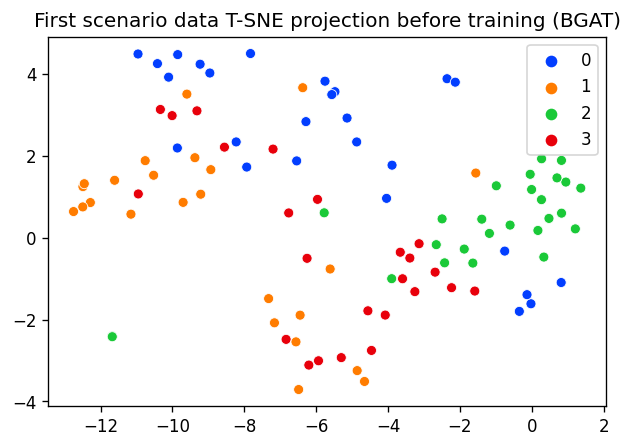

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model.

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),   lr = 0.005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        return val_loss


In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1,43):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())






  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

1 Train Loss: 2.201 | val Loss: 0.778
2 Train Loss: 0.766 | val Loss: 0.492
3 Train Loss: 0.498 | val Loss: 0.418
4 Train Loss: 0.446 | val Loss: 0.383
5 Train Loss: 0.417 | val Loss: 0.359
6 Train Loss: 0.391 | val Loss: 0.342
7 Train Loss: 0.366 | val Loss: 0.329
8 Train Loss: 0.348 | val Loss: 0.314
9 Train Loss: 0.331 | val Loss: 0.294
10 Train Loss: 0.315 | val Loss: 0.265
11 Train Loss: 0.299 | val Loss: 0.239
12 Train Loss: 0.285 | val Loss: 0.223
13 Train Loss: 0.273 | val Loss: 0.211
14 Train Loss: 0.262 | val Loss: 0.202
15 Train Loss: 0.251 | val Loss: 0.194
16 Train Loss: 0.241 | val Loss: 0.187
17 Train Loss: 0.231 | val Loss: 0.181
18 Train Loss: 0.221 | val Loss: 0.175
19 Train Loss: 0.211 | val Loss: 0.169
20 Train Loss: 0.202 | val Loss: 0.163
21 Train Loss: 0.192 | val Loss: 0.156
22 Train Loss: 0.183 | val Loss: 0.148
23 Train Loss: 0.174 | val Loss: 0.141
24 Train Loss: 0.166 | val Loss: 0.135
25 Train Loss: 0.158 | val Loss: 0.131
26 Train Loss: 0.151 | val Loss: 0

# Visualize train loss and val loss.


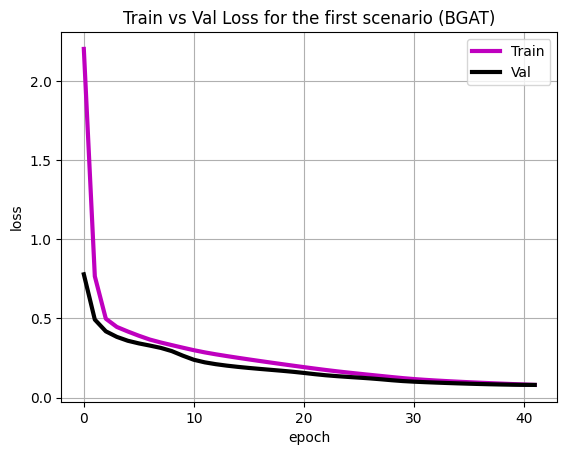

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the first scenario (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim = 1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc


In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 90.00


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (8, 6),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",4)).set(title = "First scenario data T-SNE projection after training (BGAT)")

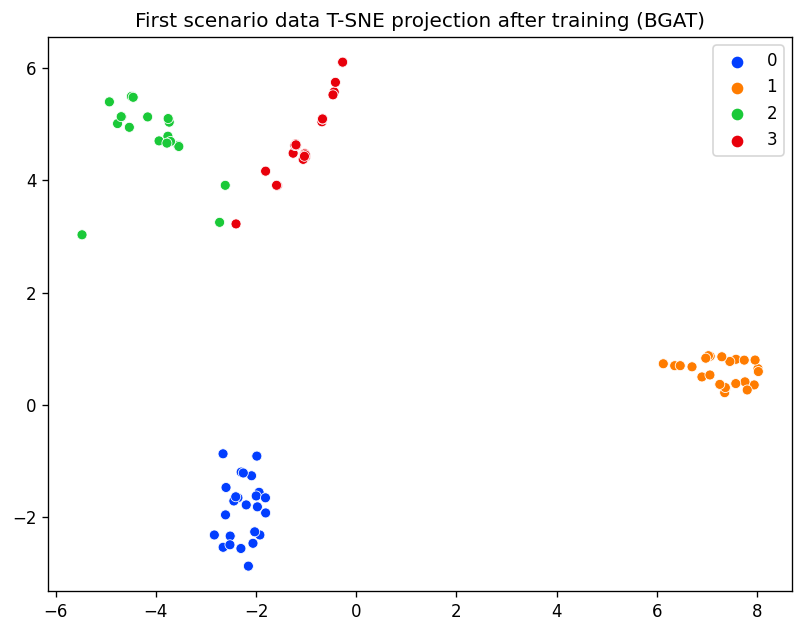

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred_t = out.argmax(dim=1)
pred_t

tensor([0, 1, 3, 3, 3, 1, 0, 3, 3, 3, 2, 2, 2, 0, 3, 2, 2, 1, 3, 1, 0, 1, 2, 1,
        1, 3, 3, 1, 2, 3, 2, 1, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 2, 2, 2,
        2, 2, 0, 2, 3, 0, 2, 3, 2, 3, 0, 3, 3, 2, 3, 1, 2, 2, 2, 0, 1, 0, 2, 1,
        0, 0, 1, 2, 2, 3, 0, 2, 3, 0, 1, 1, 0, 0, 0, 2, 3, 1, 1, 0, 1, 3, 3, 0,
        1, 1, 2, 0])

In [ ]:
Data["y"]

tensor([0, 1, 3, 3, 3, 1, 0, 3, 3, 3, 2, 2, 2, 0, 3, 2, 2, 1, 3, 1, 0, 1, 2, 1,
        1, 3, 3, 1, 2, 3, 3, 1, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 0, 0, 1, 2, 2, 2,
        2, 2, 0, 2, 3, 0, 2, 3, 2, 3, 0, 3, 3, 2, 3, 1, 2, 2, 2, 0, 1, 0, 2, 1,
        0, 0, 1, 2, 2, 3, 0, 2, 3, 0, 1, 1, 0, 0, 0, 2, 3, 1, 1, 0, 1, 3, 3, 0,
        1, 1, 2, 0])

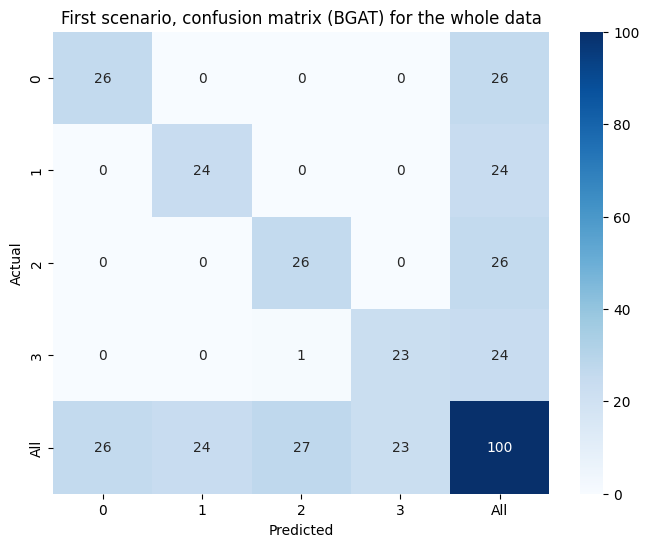

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(Data['y'], pred_t, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('First scenario, confusion matrix (BGAT) for the whole data')
plt.show()

In [ ]:
pred = pred_t[Data["test_mask"]]

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,0
1,3,2
2,2,2
3,3,3
4,0,0
5,2,2
6,2,2
7,0,0
8,1,1
9,1,1


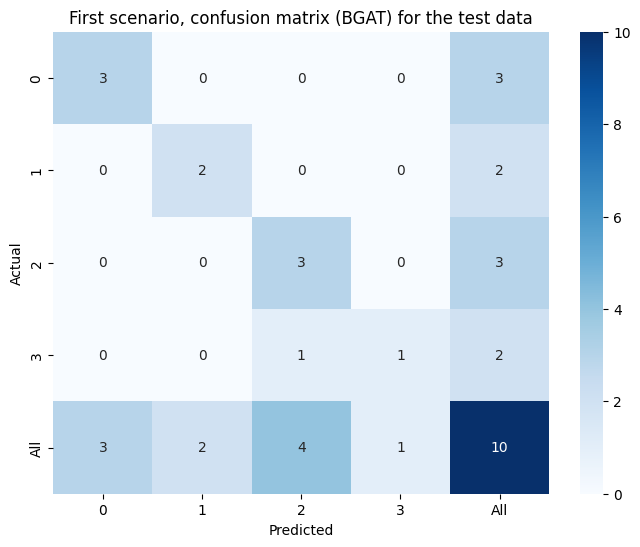

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(act, pred, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('First scenario, confusion matrix (BGAT) for the test data')
plt.show()